<h1 align="center">Estatística Computacional</h1>
<h3 align="center">Gabriel Lima Novais</h3>
<p> O trabalho final será a implementação do algoritmo conhecido como <b>Double Metropolis-Hastings</b> (DMH) para redes, mais especificamente, para <b>Exponential Random Graphs Models</b> (ERGM). A replicação será do artigo "Bayesian Analysis for Exponential Random Graph Models Using the Double Metropolis-Hastings Sampler", cujos autores são Ick Hoon Jin e Faming Liang. O link do artigo encontra-se destacado abaixo.</p>


<p><a href="https://amstat.tandfonline.com/doi/full/10.1080/01621459.2018.1448824">Artigo de Apoio</a></p>
<p><a href="https://www.researchgate.net/publication/265920670_Bayesian_Analysis_for_Exponential_Random_Graph_Models_Using_the_Double_Metropolis-Hastings_Sampler">Artigo de Replicação</a></p>

<p>Link do repositório no github:</p>
<ul>
    <li><a href="https://github.com/NovaisGabriel/-Computational-Statistics">Repositório do Aluno</a></li>
   </ul>


<p>Links interessantes sobre o assunto:</p>
<ul>
    <li><a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3956133/">Artigo 1</a></li>
    <li><a href="https://www.researchgate.net/publication/236264661_A_Monte_Carlo_Metropolis-Hastings_Algorithm_for_Sampling_from_Distributions_with_Intractable_Normalizing_Constants/link/02e7e536166f37096b000000/download">Artigo 2</a></li>
    <li><a href="https://arxiv.org/pdf/1904.08063.pdf">Artigo 3</a></li>
</ul>

### Importando Pacotes:

In [8]:
using StatsBase
using LinearAlgebra
using StatsKit
using Plots
using ProgressMeter

### Função $D(net)$
<ul>
    <li><b>Input:</b> Matriz de Adjacência de uma rede não direcionada.</li>
<li><b>Output:</b> Vetor com número em ordem crescente de pontos com exatamente aquela quantidade de arestas.</li>
    </ul>

In [9]:
function D(net)
    ans = zeros(length(net[:,1]))
    aux = countmap(sum(net,dims=2)[:])
    for i = 1:length(net[:,1])
        try
            ans[i] = aux[i-1]
            catch
            ans[i] = 0
        end   
    end
    return ans
end

D (generic function with 1 method)

### Função EP(net)
<ul>
    <li><b>Input:</b> Matriz de Adjacência de uma rede não direcionada.</li>
<li><b>Output:</b> Vetor com número em ordem crescente de pares com exatamente aquela quantidade de vizinhos em comum.</li>
    </ul>

In [10]:
function EP(net)
    pairs = zeros(length(net[:,1]))
    l = length(net[:,1])
    for node1=1:l
        for node2=node1+1:l
            if net[node1,node2]>0
                v = sum((net[node1,:].+net[node2,:]).==2)
                pairs[v+1]+=1
            end
        end
    end
    
    return pairs
end

EP (generic function with 1 method)

### Função NE(net)
<ul>
    <li><b>Input:</b> Matriz de Adjacência de uma rede não direcionada.</li>
<li><b>Output:</b> Estatística Suficiente $e(x)$ descrita no artigo</li>
    </ul>
<img src="S1.png">

In [11]:
function NE(net)
    return 0.5*((0:length(net[:,1])-1)'*D(net))
end

NE (generic function with 1 method)

### Função GWD(net)
<ul>
    <li><b>Input:</b> Matriz de Adjacência de uma rede não direcionada.</li>
<li><b>Output:</b> Estatística Suficiente $u(x|\tau)$ descrita no artigo</li>
    </ul>
<img src="S2.png">

In [12]:
function GWD(net,tau)
    gwdaux(i,tau,di) = (1-(1-exp(-tau))^i)*di
    di = D(net)[2:end-1]
    i=1:length(net[:,1])-2
    return exp(tau)*sum(gwdaux.(i,tau,di))
end

GWD (generic function with 1 method)

### Função GWESP(net)
<ul>
    <li><b>Input:</b> Matriz de Adjacência de uma rede não direcionada.</li>
<li><b>Output:</b> Estatística Suficiente $v(x|\tau)$ descrita no artigo</li>
    </ul>
<img src="S3.png">

In [13]:
function GWESP(net,tau)
    gwdaux(i,tau,di) = (1-(1-exp(-tau))^i)*di
    di = EP(net)[2:end-2]
    i=1:length(di)
    return exp(tau)*sum(gwdaux.(i,tau,di))
end

GWESP (generic function with 1 method)

### Funções de Modelo
<ul>
    <li><b>Input:</b> Matriz de Adjacência de uma rede não direcionada.</li>
<li><b>Output:</b> função de distribuição exponencial a partir das estatísticas suficientes denotada no artigo como $f(x|\theta)$</li>
    </ul>
<img src="Models.png">

In [14]:
function model1(x,theta,tau)
    return exp(theta'*[NE(x),GWD(x,tau)])
end

model1 (generic function with 1 method)

In [15]:
function model2(x,theta,tau)
    return exp(theta'*[NE(x),GWESP(x,tau)])
end

model2 (generic function with 1 method)

In [16]:
function model3(x,theta,tau)
    return exp(theta'*[NE(x),GWD(x,tau),GWESP(x,tau)])
end

model3 (generic function with 1 method)

### Função DMH(net)
<ul>
    <li><b>Input:</b> Matriz de Adjacência de uma rede não direcionada e alguns parâmetros para o MH.</li>
<li><b>Output:</b> Amostragem da função posteriori dos $\theta$ em relação ao $x$</li>
    </ul>
O esquema do algoritmo pode ser verificado abaixo:
<img src="exp.png">

<b>OBS:</b> No passo da letra b, tal como realizado no artigo, foi utilizado apenas uma rodada de Gibbs-Sampler onde cada elemento da Matriz foi atualizado de acordo com a probabilidade abaixo:
<img src="change.png">

In [17]:
function DMH(x,dim,n_iter,ss,tau,var_init)
    
    #Informação dos Inputs:
    # x = matriz de adjacência
    # dim = quantidade de parâmetros do modelo (2 ou 3). Lembrar que se for 3 mudar o model para model3
    # n_iter = número de iterações do MH principal
    # ss = Step-Size
    # tau = parâmetro associado às Estatísiticas Suficientes do modelo em questão
    # var_init = Variância do primeiro theta. Procurar escolher um valor em torno de 100.
    
    #Inicialização:
    thetas = zeros(n_iter,2)
    thetas[1,:] = rand(MvNormal(zeros(dim),var_init*Matrix{Float64}(I,dim,dim)))
    
    #Primeiro theta atual
    tnow = thetas[1,:]
    
    #Parâmetros Iniciais
    l =  length(x[1,:])
    p = Progress(n_iter, 1)
    
    #Início do Primeiro MH
    for t=1:n_iter
        
        tline = rand(MvNormal(tnow,(ss^2)*Matrix{Float64}(I,dim,dim)))
        
        y = copy(x)
        
        #Início do Segundo MH
        for i=1:l
            for j=1:l
                if i<j
                    z=copy(y)
                    w=copy(y)
                    z[i,j]=1
                    z[j,i]=1 
                    w[i,j]=0
                    w[j,i]=0
                    
                    #Aceitação
                    num = model2(z,tline,tau)
                    den = model2(w,tline,tau)+model2(z,tline,tau)
                    prob = num/den

                    if rand()<prob
                        y[i,j]=1
                        y[j,i]=1
                    else
                        y[i,j]=0
                        y[j,i]=0
                    end
                    
                end
            end

        end
        
        #Aceitação:
        low = log(model2(x,tnow,tau))+log(model2(y,tline,tau))
        high = log(model2(y,tnow,tau))+log(model2(x,tline,tau))
        r = exp(high-low)
        alpha = minimum([1,r])
        
        if rand()<alpha
            thetas[t,:] = tline
            tnow = tline
        end
    next!(p)
    end
    
    return thetas
end

DMH (generic function with 1 method)

### Aplicando o DMH:

##### 1) Rede de tamanho 10:
Vamos então a partir das funções acima realizar o procedimeto de estimação dos parâmetros $\theta_1$=-1.66  e  $\theta_2$=0.15 da rede de tamanho de 10 da base Florentine.
A matriz de adjacência encontra-se destacada abaixo com o nome de "florentine".

In [51]:
#Rede
florentine =[0. 1. 1. 1. 1. 0. 0. 1. 0. 0.;
             1. 0. 0. 0. 1. 1. 0. 0. 1. 1.;
             1. 0. 0. 1. 1. 0. 0. 1. 1. 1.;
             1. 0. 1. 0. 0. 0. 0. 0. 1. 1.;
             1. 1. 1. 0. 0. 0. 0. 0. 0. 1.;
             0. 1. 0. 0. 0. 0. 0. 0. 0. 1.;
             0. 0. 0. 0. 0. 0. 0. 1. 1. 0.;
             1. 0. 1. 0. 0. 0. 1. 0. 1. 1.;
             0. 1. 1. 1. 0. 0. 1. 1. 0. 0.;
             0. 1. 1. 1. 1. 1. 0. 1. 0. 0.]
#DMH
result10 = DMH(florentine,2,10500,0.2,0.25,200)
thetas10 = result10[result10[:,1] .!= 0,:]
#Retirando o Burn In
thetas10BI = thetas10[500:end,:] 

#Plot thetas pela iteração
plot(thetas10)

Progress:   2%|▋                                        |  ETA: 0:12:21

InterruptException: InterruptException:

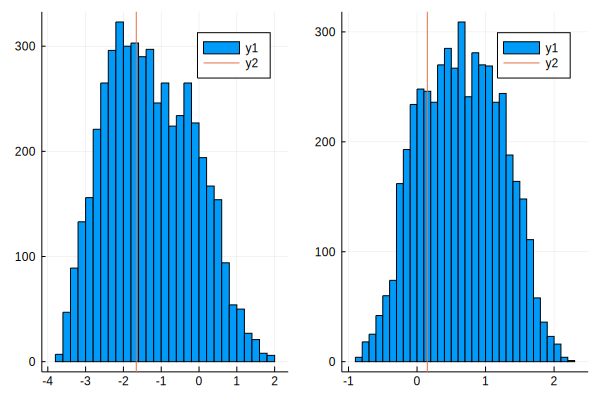

In [52]:
histogram(thetas10BI[:,1])
p1 = vline!([-1.66])
histogram(thetas10BI[:,2])
p2 = vline!([0.15])
plot(p1,p2,layout=2)

##### 2) Rede de tamanho 50:
A obtenção desta rede foi realizada pela geração de grafos de um pacote em R, e depois de acordo os métodos de MCMCMLE foram recuperados os parâmetros de acordo com um distribuição exponencial dos nós (ERGM).
Os parâmetros recuperados para esta rede seriam de $\theta_1$ = -3.19 e $\theta_2$=0.39

In [56]:
#Obtendo a rede de 50 nós
a = CSV.read("graph.csv")
teste50 = convert(Matrix, a)[:,2:end]

50×50 Array{Int64,2}:
 0  1  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  1  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  1  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  1  1  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  0    

In [55]:
#DMH
result50 = DMH(teste50,2,1000,0.2,0.25,200)
thetas50 = result50[result50[:,1] .!= 0,:]
#Retirando o Burn In
thetas50BI = thetas50[50:end,:] 

#Plot thetas pela iteração
plot(thetas50)

Progress:   1%|▎                                        |  ETA: 4:24:54

InterruptException: InterruptException:

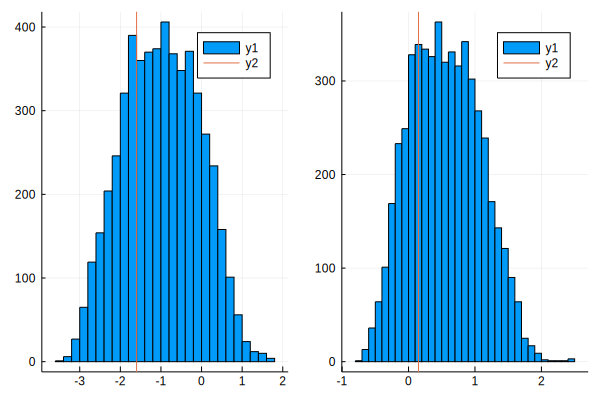

In [315]:
histogram(thetas50BI[:,1])
p1 = vline!([-3.19])
histogram(thetas50BI[:,2])
p2 = vline!([0.39])
plot(p1,p2,layout=2)